Welcome to the tutorial on Ragas. Ragas is a framework that helps you evaluate your Retrieval Augmented Generation (RAG) pipelines. The RAG pipeline is broken down into three components: 1. Indexing, 2. Retrieval, and 3. Generation. Ragas leverage LLMs to evaluate the Retrieval and Generation part

Let's first download all the necessary packages

## Install necessary packages

In [ ]:
pip install -q ragas pandas tiktoken datasets langchain==0.0.339 chromadb openai==1.3.5


## Import necessary libraries

In [ ]:
import os
import pandas as pd
from datasets import load_dataset
from langchain.document_loaders import WebBaseLoader
from dotenv import load_dotenv, find_dotenv
from langchain.indexes import VectorstoreIndexCreator
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import TokenTextSplitter
from ragas.langchain.evalchain import RagasEvaluatorChain
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_relevancy,
    context_recall,
)

import openai
from ragas import evaluate

## OpenAI api key

Ragas uses OpenAI to evaluate RAG pipelines.

1. Run nano ~/.env
2. OPENAI_API_KEY = "your open ai api key"

In [ ]:
# read local .env file
_ = load_dotenv(find_dotenv()) 

## Evaluating QA system (no ground truth available)



1.   Load the wikipedia page. We will use langchain to QA this page
2.   Split the entire page using TokenTextSplitter
3.   Use openai to create embeddings for each split
4.   Create a vector database using Chroma
5.   Retrieve answers from the database



In [ ]:
# load the Wikipedia page
loader = WebBaseLoader("https://en.wikipedia.org/wiki/OpenAI")

data = loader.load()
chunk_size = 1000
chunk_overlap = 200
text_splitter = TokenTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

#split the document as per chunksize and chunkoverlap
splitdocument = text_splitter.split_documents(data)

#create embeddings
embeddings = OpenAIEmbeddings()

In [ ]:
splitdocument[0].page_content.split('\n')

In [ ]:
# Create a vector database using Chroma
vectDB = Chroma.from_documents(splitdocument,embeddings)
retriever = vectDB.as_retriever(return_source_document=True)

In [ ]:
# create the QA chain
llm = ChatOpenAI(temperature=0)
qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever,
                                 return_source_documents=True)



# testing it out
question = "Where is the company OpenAI registered?"
result = qa({"query": question})
result["result"]

In [ ]:
result

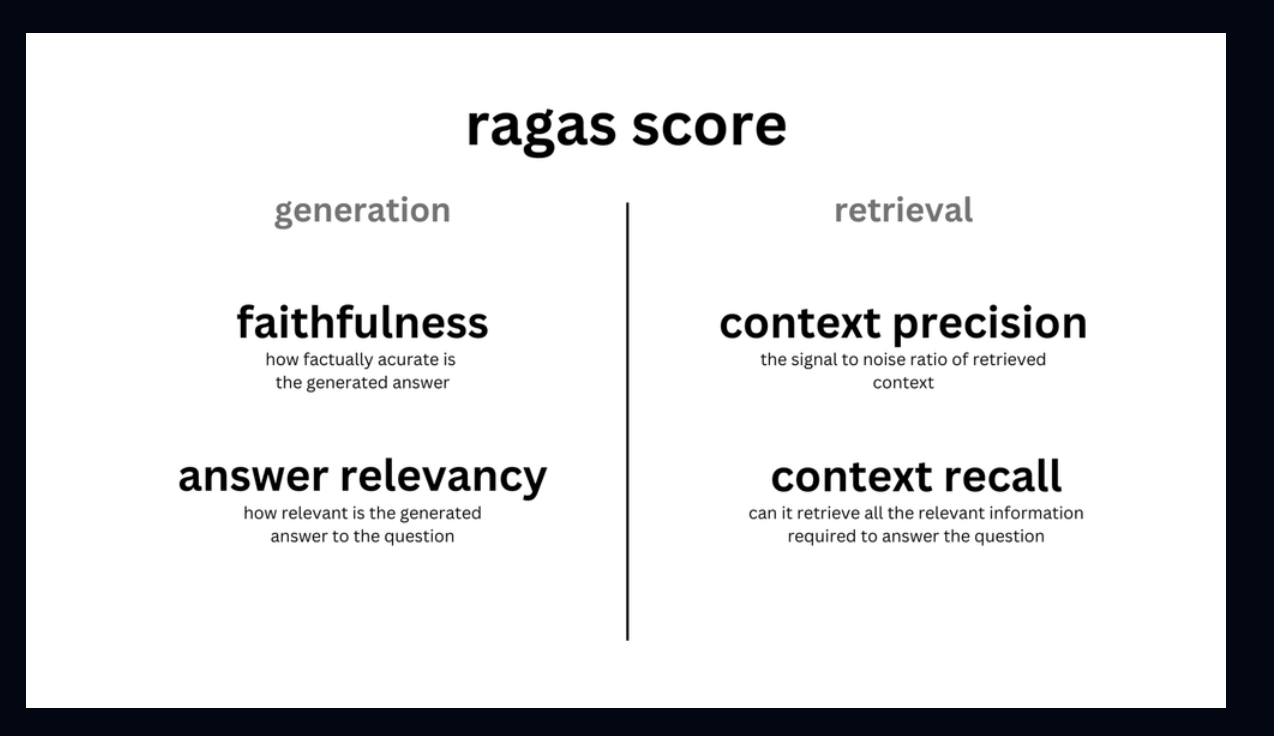

In [ ]:
# create evaluation chains
faithfulness_chain = RagasEvaluatorChain(metric=faithfulness)
#answer_rel_chain = RagasEvaluatorChain(metric=answer_relevancy)

In [ ]:
eval_result = faithfulness_chain(result)
print(eval_result["faithfulness_score"])

# eval_result = answer_rel_chain(result)
# print(eval_result["answer_relevancy_score"])